In [12]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

train_df = pd.read_csv("/kaggle/input/hull-tactical-market-prediction/train.csv")

In [15]:
train_df.columns

Index(['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1',
       'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19',
       'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3',
       'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12', 'M13',
       'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7',
       'M8', 'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5',
       'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4',
       'S5', 'S6', 'S7', 'S8', 'S9', 'V1', 'V10', 'V11', 'V12', 'V13', 'V2',
       'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'forward_returns',
       'risk_free_rate', 'market_forward_excess_returns'],
      dtype='object')

Handling missing values using forward fill...
Missing values handled.
Training data shape: (7642, 95)
Validation data shape: (1348, 95)

Training LightGBM model...
Training until validation scores don't improve for 100 rounds


/tmp/ipykernel_36/174815380.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df.fillna(method='ffill', inplace=True)


Early stopping, best iteration is:
[109]	valid_0's rmse: 0.0105253

Validation RMSE: 0.010525303594489168

Sample of submission file:
      date_id  allocation
7642     7642    0.046636
7643     7643    0.049387
7644     7644    0.018024
7645     7645    0.069605
7646     7646    0.000000


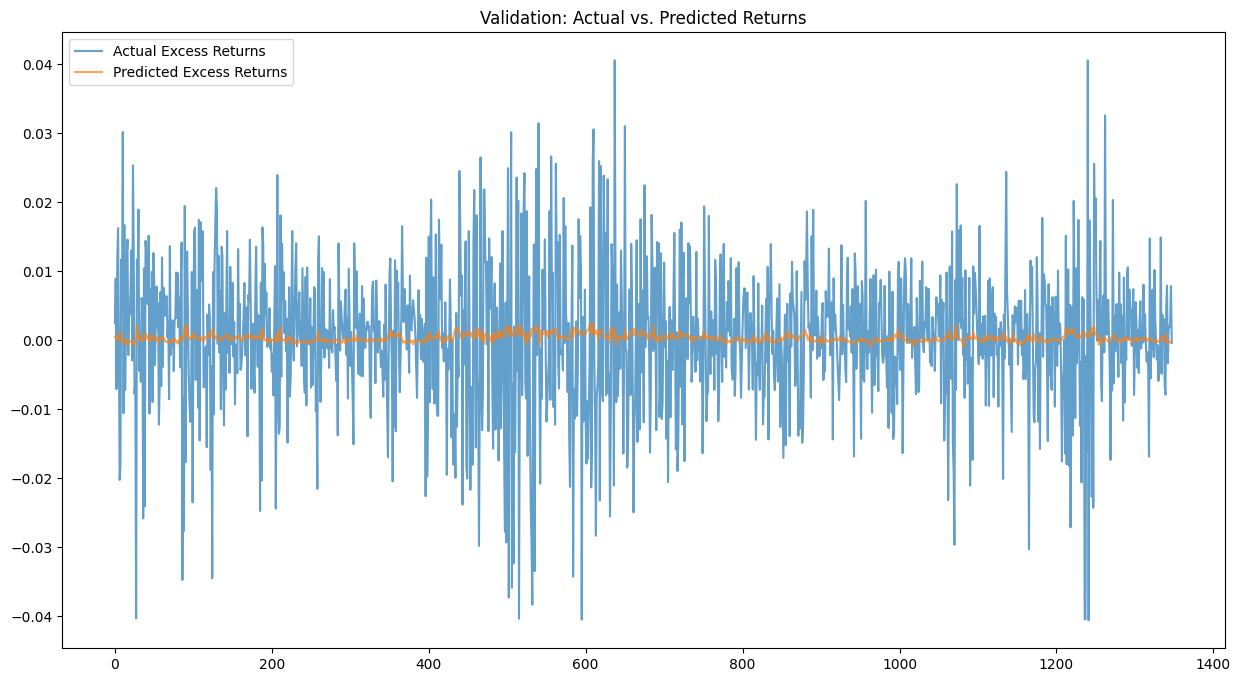

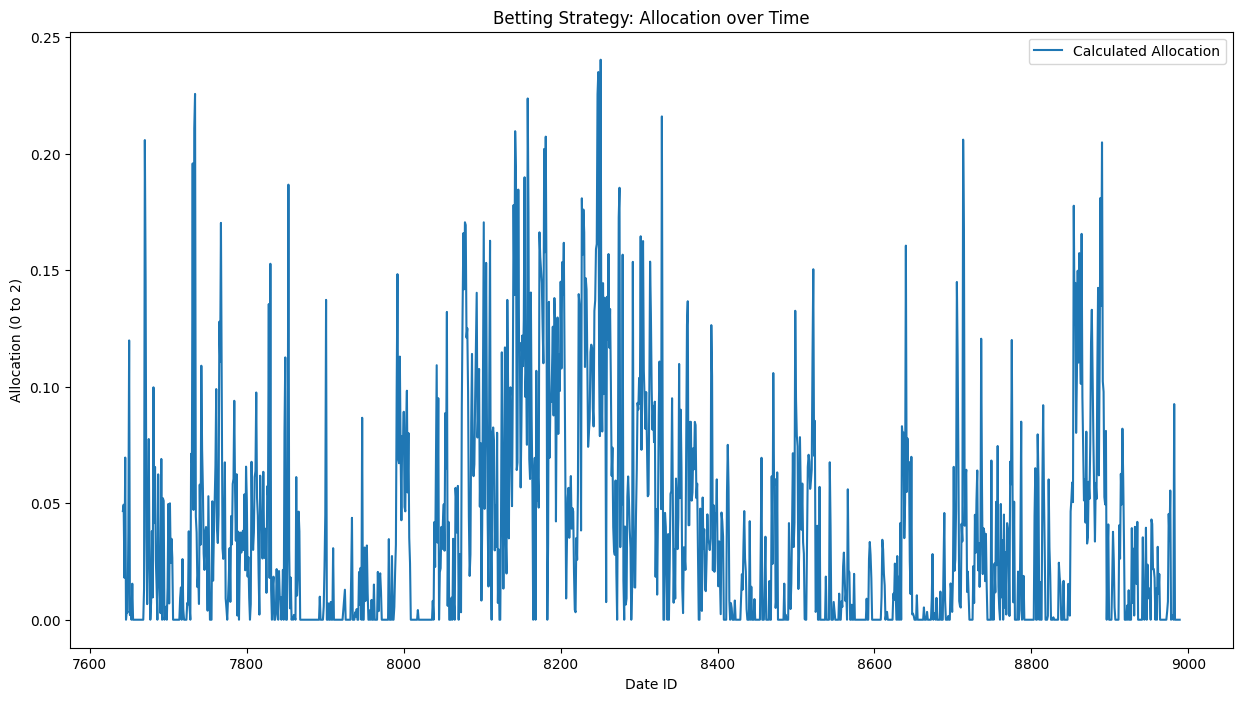

In [13]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt


print("Handling missing values using forward fill...")
train_df.fillna(method='ffill', inplace=True)


train_df.fillna(0, inplace=True)
print("Missing values handled.")


features = [col for col in train_df.columns if col not in [
    'forward_returns',
    'risk_free_rate',
    'market_forward_excess_returns'
]]
target = 'market_forward_excess_returns'

X = train_df[features]
y = train_df[target]

val_size = int(len(X) * 0.15)
X_train, X_val = X[:-val_size], X[-val_size:]
y_train, y_val = y[:-val_size], y[-val_size:]

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

lgb_params = {
    'objective': 'regression_l1',  # L1 loss is often more robust to outliers
    'metric': 'rmse',
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'num_leaves': 31,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42,
    'boosting_type': 'gbdt',
}

print("\nTraining LightGBM model...")
model = lgb.LGBMRegressor(**lgb_params)

# Train the model with early stopping to prevent overfitting
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          eval_metric='rmse',
          callbacks=[lgb.early_stopping(100, verbose=True)])


predictions = model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, predictions))
print(f"\nValidation RMSE: {rmse}")


scaling_factor = 100 # This is a guess, you should tune this value

allocations = predictions * scaling_factor

allocations = np.clip(allocations, 0, 2)

# Create a submission DataFrame
submission_df = pd.DataFrame({'date_id': X_val['date_id'], 'allocation': allocations})
print("\nSample of submission file:")
print(submission_df.head())

# Visualize our predictions vs actuals and the resulting allocation
plt.figure(figsize=(15, 8))
plt.plot(y_val.values, label='Actual Excess Returns', alpha=0.7)
plt.plot(predictions, label='Predicted Excess Returns', alpha=0.7)
plt.title('Validation: Actual vs. Predicted Returns')
plt.legend()
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(submission_df['date_id'], submission_df['allocation'], label='Calculated Allocation')
plt.title('Betting Strategy: Allocation over Time')
plt.xlabel('Date ID')
plt.ylabel('Allocation (0 to 2)')
plt.legend()
plt.show()
